In [542]:
from __future__ import print_function

!sudo python3.7 -m pip install matplotlib

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np 
from sys import argv
import torchvision.transforms as transforms
import copy
import librosa
from scipy import ndimage

In [543]:
class CNNModel(nn.Module):
		def __init__(self):
			super(CNNModel, self).__init__()
			self.cnn1 = nn.Conv1d(in_channels=1025, out_channels=4096, kernel_size=3, stride=1, padding=1)
			#self.nl1 = nn.ReLU()
			#self.pool1 = nn.AvgPool1d(kernel_size=5)
			#self.fc1 = nn.Linear(4096*2500,2**5)
			#self.nl3 = nn.ReLU()
			#self.fc2 = nn.Linear(2**10,2**5)
		
		def forward(self, x):
			out = self.cnn1(x)
			#out = self.nl1(out)
			#out = self.pool1(out)
			out = out.view(out.size(0),-1)
			#out = self.fc1(out)
			#out = self.nl3(out)
			#out = self.fc2(out)
			return out

In [544]:
class GramMatrix(nn.Module):

	def forward(self, input):
		a, b, c = input.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)
		features = input.view(a * b, c)  # resise F_XL into \hat F_XL
		G = torch.mm(features, features.t())  # compute the gram product
        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
		return G.div(a * b * c)

In [545]:
class StyleLoss(nn.Module):

    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() 
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = 0.0
        for i in range(self.target.shape[0]):
            self.loss += self.criterion(self.G, self.target[i, :, :] * self.weight)
        self.loss = self.loss / self.target.shape[0]
        return self.output

    def backward(self,retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [546]:
class ContentLoss(nn.Module):
    
    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        self.target = target.detach
        self.weight = weight
    
    def forward(self, input):
        self.output = input.clone()
        difference = (input - self.target) ** 2
        self.loss = self.weight * torch.sum(difference)
        return self.output
    
    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [547]:
class TotalLoss(nn.Module):
    
    def __init__(self, content_target, content_weight, style_targets, style_weight):
        super(TotalLoss, self).__init__()
        self.content_target = content_target.detach()
        self.content_weight = content_weight
        self.style_targets = style_targets.detach()
        self.style_weight = style_weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()
        self.tv_weight = 5e-3
        
    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.style_weight)
        self.loss = 0.0
        for i in range(self.style_targets.shape[0]):
            self.loss += self.criterion(self.G, self.style_targets[i, :, :] * self.style_weight)
        self.loss = self.loss / self.style_targets.shape[0]
        style_loss = self.loss.clone()
        self.loss += self.content_weight * (self.criterion(input, self.content_target))
        content_loss = self.loss.clone() - style_loss
        # TV LOSS
        self.loss += self.tv_weight * (self.criterion(input[:, :-1, :], input[:, 1:, :]) + self.criterion(input[:, :, :-1], input[:, :, 1:]))
        tv_loss = self.loss.clone() - style_loss - content_loss
        print("Style Loss ", style_loss)
        print("Content Loss", content_loss)
        print("TV Loss", tv_loss)
        return self.output
    
    def backward(self,retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [548]:
	N_FFT=2048
	def read_audio_spectum(filename):
		x, fs = librosa.load(filename, duration=58.04) # Duration=58.05 so as to make sizes convenient
		S = librosa.stft(x, N_FFT)
		p = np.angle(S)
		S = np.log1p(np.abs(S))  
		return S, fs

In [549]:
style_layers_default = ['conv_1']

style_weight=10000
content_weight=5e-3
    
def get_style_model_and_losses(cnn,input_float, style_float,style_weight=style_weight, style_layers=style_layers_default): #STYLE WEIGHT
        cnn = copy.deepcopy(cnn)
        losses = []
        model = nn.Sequential()  # the new Sequential module network
        gram = GramMatrix()  # we need a gram module in order to compute style targets
        if torch.cuda.is_available():
            model = model.cuda()
            gram = gram.cuda()

        name = 'conv_1'
        model.add_module(name, cnn.cnn1)
        if name in style_layers:
            target_feature_grams = []
            for i in range(style_float.shape[0]):
                target_feature = model(style_float[i, :, :, :]).clone()
                target_feature_gram = gram(target_feature)
                target_feature_grams.append(target_feature_gram.unsqueeze_(0))
            target_feature_grams = torch.cat(target_feature_grams, 0)
            content_target = cnn.cnn1(input_float)
            loss = TotalLoss(content_target, content_weight, target_feature_grams, style_weight)
            model.add_module("loss_1", loss)
            losses.append(loss)
            return model, losses

In [550]:
	learning_rate_initial = 0.05

	def get_input_param_optimizer(input_float):
		input_param = nn.Parameter(input_float.data)
		#optimizer = optim.Adagrad([input_param], lr=learning_rate_initial, lr_decay=0.0001,weight_decay=0)
		optimizer = optim.Adam([input_param], lr=learning_rate_initial, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
		return input_param, optimizer

In [551]:
num_steps= 500
init_random = False

def run_style_transfer(cnn, style_float, input_float, num_steps=num_steps, style_weight=style_weight): #STYLE WEIGHT, NUM_STEPS
    print('Building the style transfer model..')
    model, losses= get_style_model_and_losses(cnn, input_float.clone(), style_float, style_weight)
    model_input = input_float.clone()
    if init_random:
        model_input = torch.cuda.FloatTensor(model_input.size()).uniform_(0,1)
    input_param, optimizer = get_input_param_optimizer(model_input)
    print('Optimizing..')
    run = [0]

    while run[0] <= num_steps:
        def closure():
            # correct the values of updated input image
            input_param.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_param)
            score = 0

            for l in losses:
                #print('sl is ',sl,' style loss is ',style_score)
                score += l.backward()
#             print(style_score.item())
            run[0] += 1
            if run[0] % 100 == 0:
                print("run {}:".format(run))
                print(score)
                print('Total Loss : {:8f}'.format(score.item())) #CHANGE 4->8 
                print()

            return score


        optimizer.step(closure)
    input_param.data.clamp_(0, 1)
    return input_param.data

In [552]:
#print('Enter the names of SCRIPT, Content audio, Style audio')
content_audio_name = "weeknd_10sec_sample.wav"
#style_audio_names = ["beyonce_10sec_sample.wav", "beyonce_dang_love_10sec.wav", "beyonce_resentment_10sec.wav"]
style_audio_names = ["beyonce_10sec_sample.wav"]

# USING LIBROSA

style_audios = []
style_srs = []
for style_audio_name in style_audio_names:
    style_audio, style_sr = read_audio_spectum(style_audio_name)
    style_audios.append(style_audio[np.newaxis, :, :])
    style_srs.append(style_sr)
content_audio, content_sr = read_audio_spectum(content_audio_name)

if(content_sr == style_sr):
    print('Sampling Rates are same')
else:
    print('Sampling rates are not same')
    exit()

num_samples=style_audio.shape[1]	
style_audio = np.concatenate(style_audios)
style_audio = style_audio.reshape([len(style_audios), 1,1025,num_samples])
content_audio = content_audio.reshape([1,1025,num_samples])


if torch.cuda.is_available():
    style_float = Variable((torch.from_numpy(style_audio)).cuda())
    content_float = Variable((torch.from_numpy(content_audio)).cuda())	
else:
    style_float = Variable(torch.from_numpy(style_audio))
    content_float = Variable(torch.from_numpy(content_audio))
#style_float = style_float.unsqueeze(0)

#style_float = style_float.view([1025,1,2500])

'''
print(style_float.size())
exit()
'''
#style_float = style_float.unsqueeze(0)
#content_float = content_float.unsqueeze(0)
#content_float = content_float.reshape(1025,1,2500)

#content_float = content_float.unsqueeze(0)
#content_float = content_float.squeeze(0)



cnn = CNNModel()
if torch.cuda.is_available():
    cnn = cnn.cuda()



input_float = content_float.clone()
#input_float = Variable(torch.randn(content_float.size())).type(torch.FloatTensor)


output = run_style_transfer(cnn, style_float, input_float)
if torch.cuda.is_available():
    output = output.cpu()

#output = output.squeeze(0)
output = output.squeeze(0)
output = output.numpy()
#print(output.shape)
#output = output.resize([1025,2500])


Sampling Rates are same
Building the style transfer model..
Optimizing..
Style Loss  tensor(0.0144, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0001, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0006, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0133, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0001, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0006, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0120, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0001, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0006, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0107, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0001, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0006, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0093, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0001, device='cuda:0', grad_

Style Loss  tensor(0.0007, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0007, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0007, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0007, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0007, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBa

Style Loss  tensor(0.0006, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0006, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0006, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0006, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0006, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBa

Style Loss  tensor(0.0006, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0006, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0006, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0006, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0006, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBa

Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBa

Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBa

Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBa

Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBa

Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBa

Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBa

Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBa

Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBackward0>)
Style Loss  tensor(0.0005, device='cuda:0', grad_fn=<CloneBackward>)
Content Loss tensor(0.0003, device='cuda:0', grad_fn=<SubBackward0>)
TV Loss tensor(0.0007, device='cuda:0', grad_fn=<SubBa

In [553]:
N_FFT=2048
x = librosa.core.griffinlim(output)

OUTPUT_FILENAME = 'output1D_4096_iter'+str(num_steps)+'_c'+content_audio_name+'_s'+style_audio_name+'_sw'+str(style_weight)+'_k3s1p1.wav'
librosa.output.write_wav('to_split.wav', x, style_sr)

print('DONE...')

DONE...


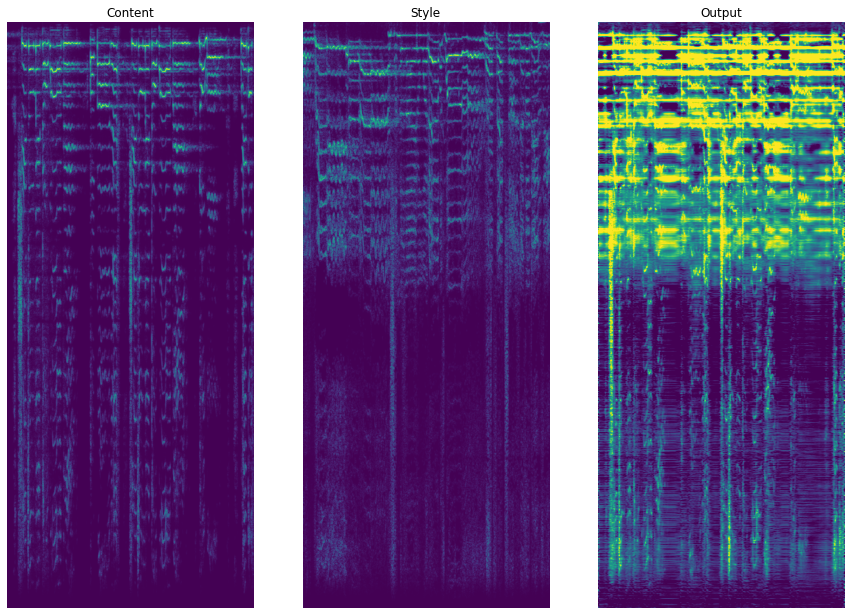

In [554]:
plt.figure(figsize=(15, 25))
plt.subplot(1,3,1)
plt.title('Content')
plt.axis('off')
plt.imshow(content_float.cpu().numpy().squeeze())
plt.subplot(1,3,2)
plt.title('Style')
plt.axis('off')
plt.imshow(style_float.cpu().numpy().squeeze())
plt.subplot(1,3,3)
plt.title('Output')
plt.axis('off')
plt.imshow(output)
plt.show()

In [555]:
from IPython.display import display as dis, Audio
dis(Audio(x, rate=22050))

## Noise Reduction

In [556]:
print(x)
dis(Audio(x, rate=22050))

[ 0.00121576  0.00229481  0.00996772 ...  0.00942886 -0.00578302
  0.01972993]
